In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from Utils.dataset import PreloadedDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

from Deep_Learning.Experimental.Forward_Forward.nn import FFNet
from Deep_Learning.Experimental.Forward_Forward.gen_neg_data import MakeNegativeSample
from Deep_Learning.Experimental.Forward_Forward.train import train_unsupervised, train_unsupervised_tracked, train_classifier

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else "cpu"
device

device(type='cuda')

Loaded MNIST with 48000 samples


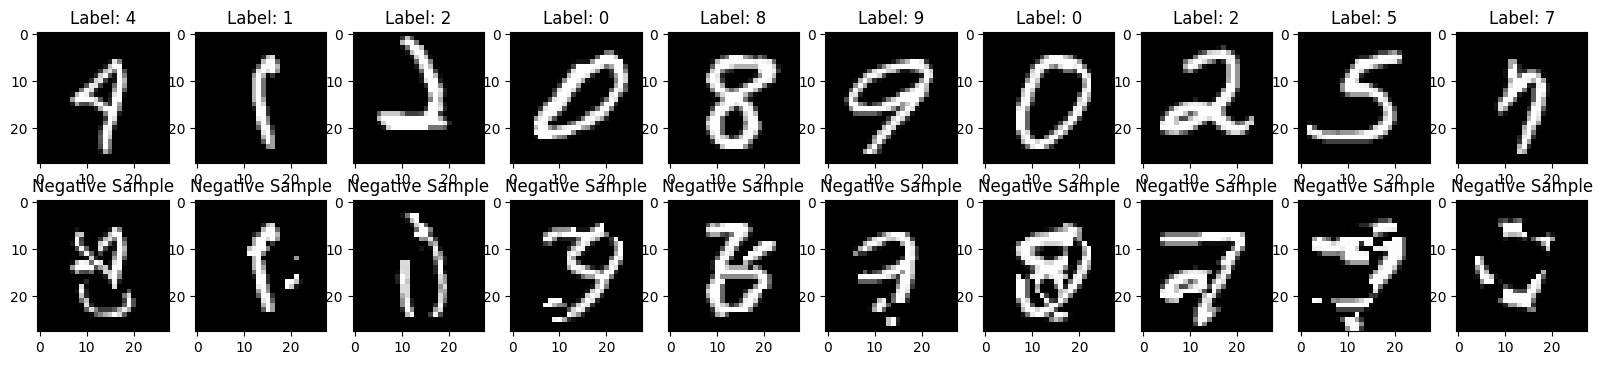

In [3]:
raw_dataset = datasets.MNIST(root="../Datasets/", train=True, transform=transforms.ToTensor(), download=True)

VAL_RATIO = 0.2
n_val = int(len(raw_dataset) * VAL_RATIO)
n_train = len(raw_dataset) - n_val
train_dataset, val_dataset = torch.utils.data.random_split(raw_dataset, [n_train, n_val])

transform = transforms.Compose([
    # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.Normalize((0.1307,), (0.3081,)),
])
pos_dataset = PreloadedDataset.from_dataset(train_dataset, transform, device)
neg_dataset = PreloadedDataset.from_dataset(pos_dataset, MakeNegativeSample(pos_dataset), device)

val_pos_dataset = PreloadedDataset.from_dataset(val_dataset, transforms.Normalize((0.1307,), (0.3081)), device)
val_neg_dataset = PreloadedDataset.from_dataset(val_pos_dataset, MakeNegativeSample(val_pos_dataset), device)

# pos_dataset.apply_transform()
print(f'Loaded MNIST with {len(pos_dataset)} samples')
# show first samples
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    axs[0,i].imshow(pos_dataset[i][0].cpu().permute(1, 2, 0), cmap='gray')
    axs[0,i].set_title(f"Label: {pos_dataset[i][1]}")
    # axs[1,i].imshow(np.squeeze(neg_dataset[i][0].cpu().numpy()), cmap='gray')
    axs[1,i].imshow(neg_dataset[i][0].cpu().permute(1, 2, 0), cmap='gray')
    axs[1,i].set_title(f"Negative Sample")
plt.show()

# Train Feedforward Networks Using Forward-Forward

In [6]:
torch.manual_seed(42)
# Parameter Initialisation
sizes = [784, 1000, 1000, 1000]
ffnet = FFNet(sizes, bias=True, threshold=2, device=torch.device(device))
tracker = None

In [7]:
# EPOCHS = [100, 100, 100, 100]
EPOCHS = 300
BATCH_SIZE = 100
LR = 1e-3
WEIGHT_DECAY=3e-4
WEIGHT_DECAY=0
MODE = "minimise"
# LOSS = "log"
LOSS = 'bce'

tracker = train_unsupervised_tracked(
# tracker = unsupervised(
    ffnet,
    LR,
    WEIGHT_DECAY,
    pos_dataset,
    neg_dataset,
    val_pos_dataset,
    val_neg_dataset,
    EPOCHS,
    BATCH_SIZE,
    MODE,
    LOSS,
    tracker,
)

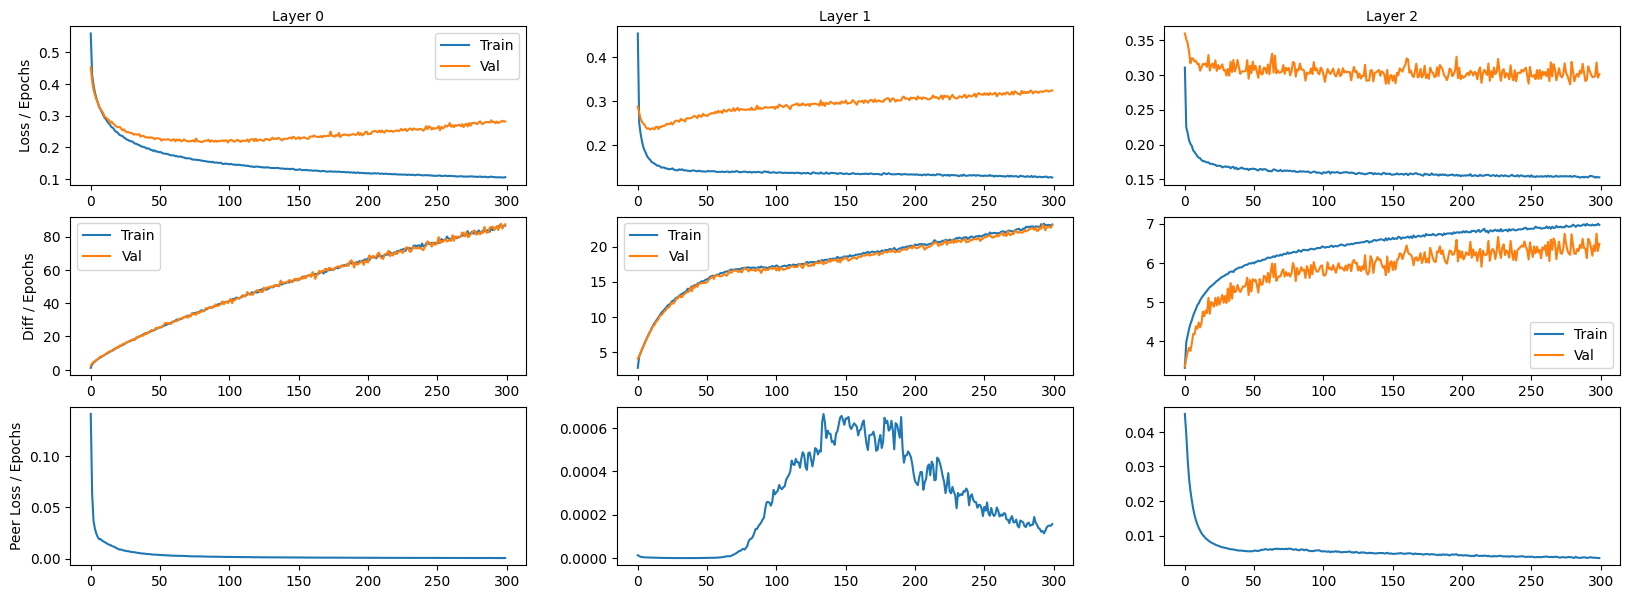

In [8]:
# Shows the loss and difference in logits betweeen pos and neg samples for each layer over training period
fig, axs = plt.subplots(3, len(ffnet.layers), figsize=(20, 7))
for i, layer in enumerate(ffnet.layers):
    axs[0,i].plot(tracker['layer_losses'][i], label="Train")
    axs[0,i].plot(tracker['layer_val_losses'][i], label="Val")
    axs[0,i].set_xlabel(f"Layer {i}")
    axs[0,i].xaxis.set_label_position('top')
    if i == 0:
        axs[0,i].set_ylabel(f"Loss / Epochs")
        axs[0,i].legend()

    axs[1,i].plot(tracker['layer_diffs'][i], label="Train")
    axs[1,i].plot(tracker['layer_val_diffs'][i], label="Val")
    axs[1,i].legend()
    if i == 0:
        axs[1,i].set_ylabel("Diff / Epochs")
    
    axs[2,i].plot(tracker['layer_peer_losses'][i])
    if i == 0:
        axs[2,i].set_ylabel("Peer Loss / Epochs")

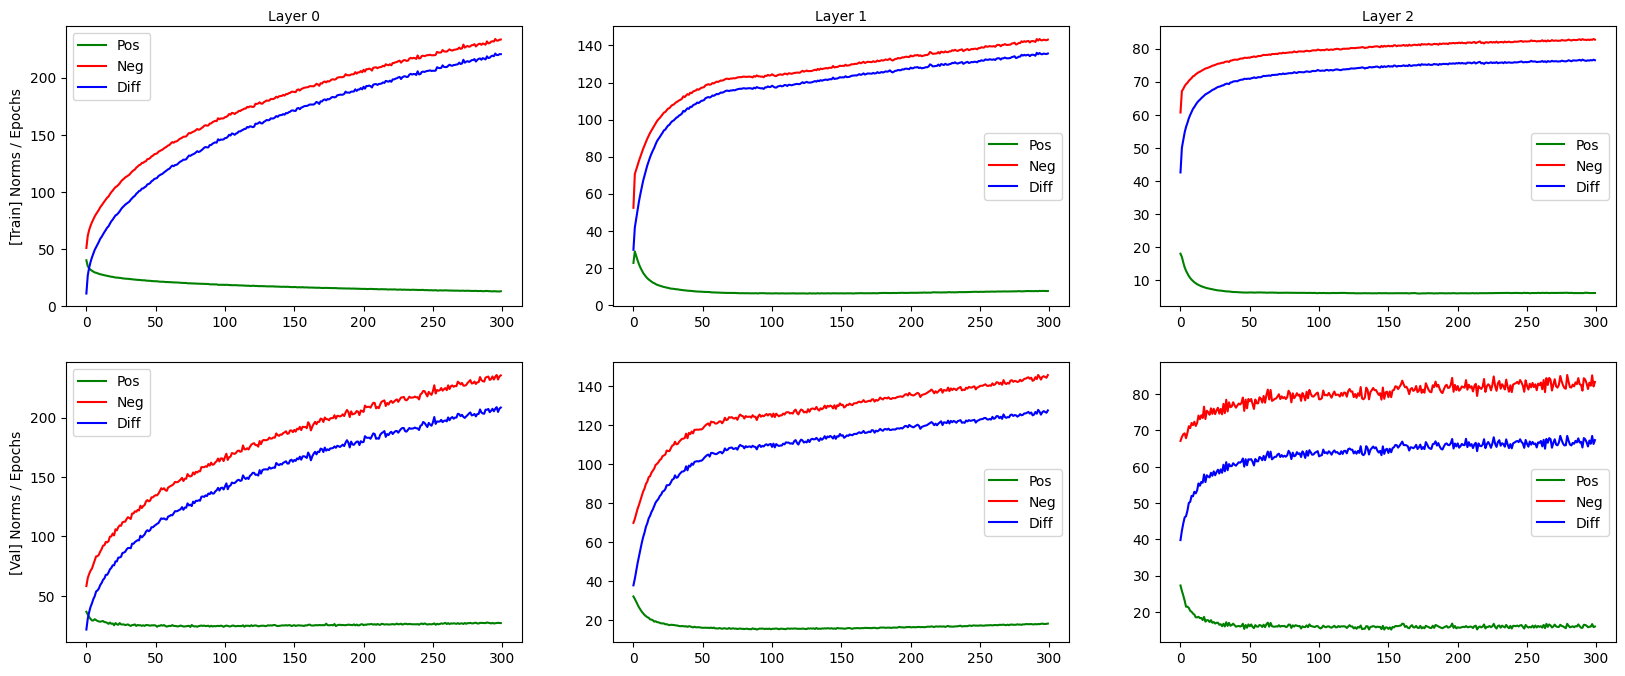

In [9]:
fig, axs = plt.subplots(2, len(ffnet.layers), figsize=(20, 8))
for i in range(len(ffnet.layers)):
    axs[0,i].plot(tracker['norms'][0][i], label="Pos", color='g')
    axs[0,i].plot(tracker['norms'][1][i], label="Neg", color='r')
    diff = [a - b for a, b in zip(tracker['norms'][0][i], tracker['norms'][1][i])]
    if MODE == "minimise":
        diff = [-x for x in diff]
    axs[0,i].plot(diff, label="Diff", color='b')
    axs[0,i].set_xlabel(f"Layer {i}")
    axs[0,i].xaxis.set_label_position('top')
    axs[0,i].legend()
    if i == 0:
        axs[0,i].set_ylabel(f"[Train] Norms / Epochs")
    axs[1,i].plot(tracker['norms'][2][i], label="Pos", color='g')
    axs[1,i].plot(tracker['norms'][3][i], label="Neg", color='r')
    diff = [a - b for a, b in zip(tracker['norms'][2][i], tracker['norms'][3][i])]
    if MODE == "minimise":
        diff = [-x for x in diff]
    axs[1,i].plot(diff, label="Diff", color='b')
    axs[1,i].legend()
    if i == 0:
        axs[1,i].set_ylabel("[Val] Norms / Epochs")

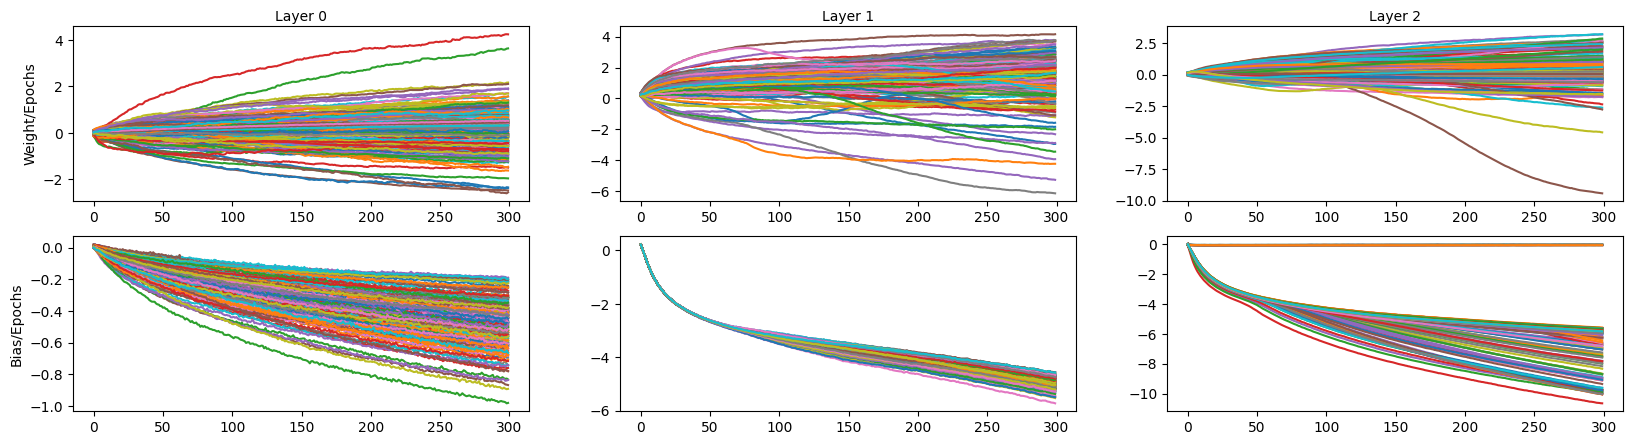

In [10]:
# Shows a subset of weights and biases for each layer over training period
k = 200 # subset size. (must be <= min layer size)
fig, axs = plt.subplots(2, len(ffnet.layers), figsize=(20, 5))
for i in range(len(ffnet.layers)):
    weights = torch.stack(tracker['weights'][i]).flatten(start_dim=1).cpu()
    idxs = torch.randperm(weights.shape[1])[:k]
    weights = weights[:, idxs]
    axs[0,i].plot(weights)
    axs[0,i].set_xlabel(f"Layer {i}")
    axs[0,i].xaxis.set_label_position('top')
    if i == 0:
        axs[0,i].set_ylabel("Weight/Epochs")

    if ffnet.layers[i].bias:
        biases = torch.stack(tracker['biases'][i]).cpu()
        idxs = torch.randperm(biases.shape[1])[:k]
        biases = biases[:, idxs]
        axs[1,i].plot(biases)
        if i == 0:
            axs[1,i].set_ylabel("Bias/Epochs")

# Train Classifier on network activations

In [11]:
LR = 1e-2
WD = 3e-3
optimiser = torch.optim.AdamW(ffnet.classifier.parameters(), lr=LR, weight_decay=WD)
criterion = nn.CrossEntropyLoss()
ffnet._init_classifier()
stats = None

In [14]:
EPOCHS = 90
BATCH_SIZE = 64
stats = train_classifier(ffnet, pos_dataset, val_pos_dataset, EPOCHS, BATCH_SIZE, optimiser, criterion, stats)

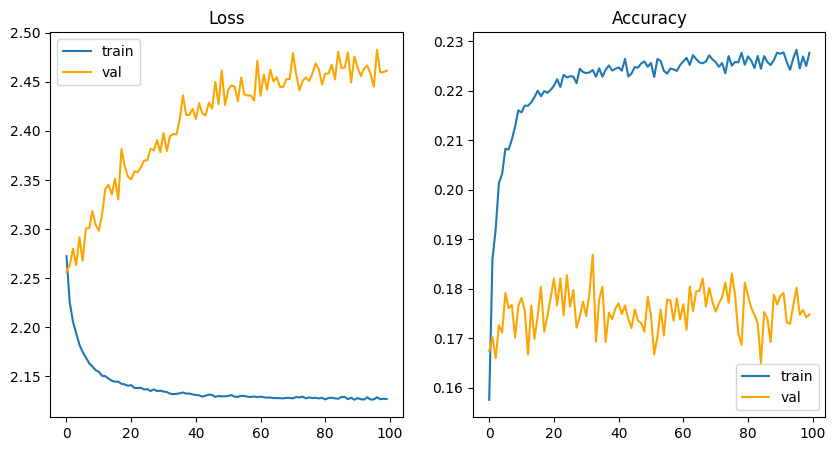

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(stats['train_loss'], label='train')
axs[0].plot(stats['val_loss'], label='val', color='orange')
axs[0].legend()
axs[0].set_title('Loss')

axs[1].plot(stats['train_acc'], label='train')
axs[1].plot(stats['val_acc'], label='val', color='orange')
axs[1].legend()
axs[1].set_title('Accuracy')

plt.show()

In [16]:
l1 = ffnet.classifier.weight.data[:,:1000].abs().mean()
l2 = ffnet.classifier.weight.data[:,1000:2000].abs().mean()
mean = ffnet.classifier.weight.data.abs().mean()

print(f"Layer 1 abs mean: {l1}")
print(f"Layer 2 abs mean: {l2}")
print(f"Overall abs mean: {mean}")

Layer 1 abs mean: 0.9230978488922119
Layer 2 abs mean: 1.2137938737869263
Overall abs mean: 1.0684459209442139
